# Exploratory Data Analysis on the Film industry

# Business Understanding

Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

# Data Understanding

The data was collected from various locations, the different files have different formats.
* [Box Office Mojo](https://www.boxofficemojo.com/)
* [IMDB](https://www.imdb.com/)
* [Rotten Tomatoes](https://www.rottentomatoes.com/)
* [TheMovieDB](https://www.themoviedb.org/)
* [The Numbers](https://www.the-numbers.com/)

Some are compressed CSV (comma-separated values) or TSV (tab-separated values), while the data from IMDB is located in a SQLite database.

<img alt='IMDB data erd' src='/movie_data_erd.jpeg' width='500px'/>


# Data Preparation

## Loading the data

In [538]:
# Importing modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

%matplotlib inline

In [539]:
# create a connection to sqlite3
conn = sqlite3.connect('zippedData/im.db')

In [540]:
# loading the data
bom_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
rt_movie_info_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter='\t')
rt_reviews_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter='\t', encoding='latin-1')
tmdb_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')
tn_budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

## Box Office Mojo

In [541]:
bom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


The data has 3397 entries with some data missing in some columns( studio, domestic_gross and foreign_gross).

There are 5 columns

Also the foreign gross is in string format

### (a). cleaning 'foreign_gross' column

In [542]:
bom_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000,652000000,2010
1,Alice in Wonderland (2010),BV,334200000,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000,664300000,2010
3,Inception,WB,292600000,535700000,2010
4,Shrek Forever After,P/DW,238700000,513900000,2010


We start off by converting the foreign_gross column to numeric data type(float64)

In [543]:
# first eliminate commas
bom_df['foreign_gross'] = bom_df.foreign_gross.map(
    lambda x: "".join(x.split(',')) if type(x) == str else x
)
bom_df['foreign_gross'] = bom_df.foreign_gross.astype(float)

bom_df.foreign_gross.dtype

dtype('float64')

Now that the column is in the correct format we can handle the missing values. 

'**The Numbers**' dataset contains budgets for some movies. We can first check some of the missing entries in the dataset.

In [544]:
# The numbers dataset
tn_budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [545]:
tn_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


no missing entries present

We start by cleaning the numeric columns to eliminate dollar sings and commas

In [546]:
def clean_money_cols(row):
    """Function to clean money columns in the tn_budgets df"""
    i = 3
    cols = ['production_budget', 'domestic_gross',	'worldwide_gross']
    while i < len(row):
        value = row[cols[i - 3]]
        if isinstance(value, str) and value.startswith('$'):
            # remove dollar sign
            value = value[1:]
            # eliminate the commas
            value = float(value.replace(',', ''))
        row[cols[i - 3]] = value
        # increment count
        i += 1
    return row

tn_budgets_df = tn_budgets_df.apply(
    lambda row: clean_money_cols(row), axis=1
)

Now that the amounts columns are in the right data type, we can add another column for foreign gross

> foreign_gross = worldwide_gross - domestic_gross

In [547]:
# creating new column for foreign gross
tn_budgets_df['foreign_gross'] = (
    tn_budgets_df.worldwide_gross - tn_budgets_df.domestic_gross
)
tn_budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,foreign_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2015837654
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,804600000
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,107000000
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,944008095
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,696540365


Fetching all the movies with missing foreign_gross

In [548]:
missing_foreign_gross = bom_df.loc[
    bom_df.foreign_gross.isna(),
    'title'
]

print('Movies missing foreign gross:', len(missing_foreign_gross))

Movies missing foreign gross: 1350


Now we try to get the foreign gross in the tn_budgets_df data

In [549]:
new_foreign_gross = tn_budgets_df.loc[
    tn_budgets_df.movie.isin(missing_foreign_gross),
    ['movie', 'foreign_gross']
]

# change columns to change movie to title
new_foreign_gross.columns = ['title', 'foreign_gross']

print('foreign gross entries found in "The Numbers" data:',
      len(new_foreign_gross))

new_foreign_gross.head()

foreign gross entries found in "The Numbers" data: 161


,title,foreign_gross
588,Evolution,60030798
946,Rock Dog,14727942
1041,Bullet to the Head,13108140
1231,The Infiltrator,5281296
1290,All Eyez on Me,9954553


Found 161 of the missing values in the other dataframe. We now fill in the values in the bom dataframe

First we check if there are 0's in the new values which also indicate missing values and remove them

In [550]:
new_foreign_gross = new_foreign_gross.loc[
    new_foreign_gross.foreign_gross != 0
]

len(new_foreign_gross)

151

Down to 151. we now fill them in the dataframe

we start by defining a helper function

In [551]:
def fill_foreign_gross(row):
    """function to fill the foreign gross column"""
    if row.title in list(new_foreign_gross.title):
        row.foreign_gross = float(
            new_foreign_gross.loc[
                new_foreign_gross.title == row.title,
                'foreign_gross'
            ].values[0]
        )
    return row

filling the values

In [552]:
bom_df = bom_df.apply(
    lambda row: fill_foreign_gross(row),
    axis=1
)

In [553]:
bom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2187 non-null   float64
 4   year            3387 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 132.4+ KB


for the remaining missing values we can fill with the mean foreign gross

In [554]:
# Handling the remaining missing values in the foreign_gross
foreign_mean = bom_df.foreign_gross.mean()

bom_df.foreign_gross.fillna(foreign_mean, inplace=True)

# check for missing values
bom_df.foreign_gross.isna().sum()

0

**Creating new column for worldwide gross**

In [555]:
# create new column for worldwide gross
bom_df['worldwide_gross'] = (
    bom_df.foreign_gross + bom_df.domestic_gross
)

bom_df.columns

Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year',
       'worldwide_gross'],
      dtype='object')

### (b). Handling missing data in domestic_gross column

We do the same for the domestic column, first try to get the missing values in the other dataframe, then fill with the mean

In [556]:
# Get the missing entries in the domestic gross columns
missing_domestic_gross = bom_df.loc[
    bom_df.domestic_gross.isna(),
    'title'
]

print('Movies missing domestic gross:', len(missing_domestic_gross))

Movies missing domestic gross: 28


In [557]:
new_domestic_gross = tn_budgets_df.loc[
    tn_budgets_df.movie.isin(missing_domestic_gross),
    ['movie', 'domestic_gross']
]

# change columns to change movie to title
new_domestic_gross.columns = ['title', 'domestic_gross']

print('domestic gross entries found in "The Numbers" data:',
      len(new_domestic_gross))

new_domestic_gross.head()

domestic gross entries found in "The Numbers" data: 2


,title,domestic_gross
3735,It's a Wonderful Afterlife,0
5382,All the Boys Love Mandy Lane,0


We found two of the movies missing the domestic gross but its still 0 meaning that its also missing in the other data source.

Therefore we replace the missing values with mean

In [558]:
# get the mean
domestic_mean = bom_df.domestic_gross.mean()

# fill the null values with mean
bom_df['domestic_gross'] = bom_df.domestic_gross.fillna(domestic_mean)

bom_df.domestic_gross.isna().sum()

0

no more missing values in the domestic gross column

In [559]:
bom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            3387 non-null   object 
 1   studio           3382 non-null   object 
 2   domestic_gross   3387 non-null   float64
 3   foreign_gross    3387 non-null   float64
 4   year             3387 non-null   int64  
 5   worldwide_gross  3359 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 158.9+ KB


The studio column has 5 missing entries

In [560]:
bom_df.studio.fillna('missing', inplace=True)

bom_df.studio.isna().sum()

0

The Box office mojo data is now clean

## IMDB

The data is in form of a sqlite database

we first check the available tables

In [561]:
table_q = """
SELECT name 
FROM sqlite_master 
WHERE type='table';
"""

pd.read_sql(table_q, conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


### 1. movie_basics

In [562]:
mb_query = """
SELECT *
FROM movie_basics
"""

movie_basics = pd.read_sql(mb_query, conn)

movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80,"Comedy,Drama,Fantasy"


This table contains the basic information about the movies eg title, and genre

In [563]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


We notice missing data in some columns. 

Lets start with the original_title column. Since there are few entries missing, we fill with the tag 'missing'

#### (a). original_title column

In [564]:
movie_basics.original_title.fillna('missing', inplace=True)

movie_basics.original_title.isna().sum()

0

#### (b). runtime_minutes column

For runtime_minutes, we can fill with the average

In [565]:
# get the mean runtime minutes
mean_runtime = movie_basics.runtime_minutes.mean()
movie_basics.runtime_minutes.fillna(mean_runtime, inplace=True)

movie_basics.runtime_minutes.isna().sum()

0

#### (c). genres column

For genres column we can try to get the missing genres in different datasets. But first we obtain the movies with missing genres

In [566]:
# movies with missing genres
missing_genres_df = movie_basics.loc[
    movie_basics['genres'].isna()
]

missing_genres_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
16,tt0187902,How Huang Fei-hong Rescued the Orphan from the...,How Huang Fei-hong Rescued the Orphan from the...,2011,86,None
22,tt0253093,Gangavataran,Gangavataran,2018,134,None
35,tt0306058,Second Coming,Second Coming,2012,95,None
40,tt0326592,The Overnight,The Overnight,2010,88,None
44,tt0330811,Regret Not Speaking,Regret Not Speaking,2011,86,None


We only need the title and the id

In [567]:
missing_genres_df = missing_genres_df.loc[
    :, ['movie_id', 'primary_title', 'original_title']
]

missing_genres_df.head()

,movie_id,primary_title,original_title
16,tt0187902,How Huang Fei-hong Rescued the Orphan from the...,How Huang Fei-hong Rescued the Orphan from the...
22,tt0253093,Gangavataran,Gangavataran
35,tt0306058,Second Coming,Second Coming
40,tt0326592,The Overnight,The Overnight
44,tt0330811,Regret Not Speaking,Regret Not Speaking


Lets start with the **Rotten tomatoes** data and check if it contains a genres column

In [568]:
rt_movie_info_df.columns

Index(['id', 'synopsis', 'rating', 'genre', 'director', 'writer',
       'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime',
       'studio'],
      dtype='object')

In [569]:
rt_movie_info_df.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


We can use the  'genre' column but there is no title column to compare to the data in missing_genres_df

Lets check **The Movie Db data** 

In [570]:
tmdb_df.columns

Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')

In [571]:
tmdb_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,34,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,8,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,29,2010-03-26,How to Train Your Dragon,8,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,29,2010-05-07,Iron Man 2,7,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28,1995-11-22,Toy Story,8,10174
4,4,"[28, 878, 12]",27205,en,Inception,28,2010-07-16,Inception,8,22186


For this data, there is a title column to compare to, but the genres are id refferencing to a genres table which we dont have access to.



Finally **The Numbers** data

In [572]:
tn_budgets_df.columns

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'foreign_gross'],
      dtype='object')

There is no column we can use to get the genres

Since we cant get the genres from the other data sources, we can fill the entries with 'missing' tag

In [573]:
movie_basics.fillna('missing', inplace=True)

movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146144 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  146144 non-null  float64
 5   genres           146144 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


There are no more missing values in the data.

We continue to check the genres column

In [574]:
movie_basics.genres.value_counts()

genres
Documentary                   32185
Drama                         21486
Comedy                         9177
missing                        5408
Horror                         4372
                              ...  
Adventure,Music,Mystery           1
Documentary,Horror,Romance        1
Sport,Thriller                    1
Comedy,Sport,Western              1
Adventure,History,War             1
Name: count, Length: 1086, dtype: int64

Some genres are combined in one entry separated by a comma. We create a new df and separate each genre and ensure each has its own row.

In [575]:
# create df as copy of ratings df
genre_df = ratings_df.copy()

# split the genres
genre_df['genres'] = genre_df.genres.str.split(',')

# one genre in each row
genre_df = genre_df.explode('genres')

genre_df.head()

,movie_id,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres
0,tt10356526,8,31,Laiye Je Yaarian,Laiye Je Yaarian,2019,117,Romance
1,tt10384606,9,559,Borderless,Borderless,2019,87,Documentary
2,tt1042974,6,20,Just Inès,Just Inès,2010,90,Drama
3,tt1043726,4,50352,The Legend of Hercules,The Legend of Hercules,2014,99,Action
3,tt1043726,4,50352,The Legend of Hercules,The Legend of Hercules,2014,99,Adventure


In [576]:
genre_df.genres.value_counts().index

Index(['Drama', 'Documentary', 'Comedy', 'Thriller', 'Horror', 'Action',
       'Romance', 'Crime', 'Adventure', 'Biography', 'Family', 'Mystery',
       'History', 'Sci-Fi', 'Fantasy', 'Music', 'Animation', 'Sport', 'War',
       'missing', 'Musical', 'News', 'Western', 'Reality-TV', 'Adult',
       'Game-Show', 'Short'],
      dtype='object', name='genres')

The genres df now has repeated

Checking for duplicates

In [577]:
movie_basics.duplicated().sum()

0

No duplicates.

We completed cleaning the movie basics table.

### 2. movie_ratings

In [578]:
mr_query = """
SELECT *
FROM movie_ratings
"""

movie_ratings = pd.read_sql(mr_query, conn)
movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8,31
1,tt10384606,9,559
2,tt1042974,6,20
3,tt1043726,4,50352
4,tt1060240,6,21


In [579]:
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


no missing values in the ratings table

Checking for duplicates

In [580]:
movie_ratings.duplicated().sum()

0

no duplicates in the movie ratings table

### 3. Directors

In [581]:
dir_query = """
SELECT 
    p.primary_name AS name,
    d.*
FROM 
    directors d
JOIN
    persons p
USING(person_id)
"""

directors = pd.read_sql(dir_query, conn)
directors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291171 entries, 0 to 291170
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   name       291171 non-null  object
 1   movie_id   291171 non-null  object
 2   person_id  291171 non-null  object
dtypes: object(3)
memory usage: 6.7+ MB


no missing values

In [582]:
directors.duplicated().sum()

127638

The  table contains many duplicates

In [583]:
directors.drop_duplicates(inplace=True)

directors.duplicated().sum()

0

### 4. Writers

In [584]:
wr_query = """
SELECT
    p.primary_name AS name,
    w.*
FROM
    writers w
JOIN
    persons p
USING(person_id)
"""

writers = pd.read_sql(wr_query, conn)
writers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255871 entries, 0 to 255870
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   name       255871 non-null  object
 1   movie_id   255871 non-null  object
 2   person_id  255871 non-null  object
dtypes: object(3)
memory usage: 5.9+ MB


No missing values in this table.

Checking for duplicates

In [585]:
# check duplicates
writers.duplicated().sum()

77521

the table has many duplicates

In [586]:
writers.drop_duplicates(inplace=True)

# check duplicates
writers.duplicated().sum()

0

# Data Analysis

In [587]:
# suppressing scientific notation
pd.options.display.float_format = '{:.0f}'.format

## 1. Best income generating studios

We use the Box Office Mojo data

In [588]:
bom_df.head()

,title,studio,domestic_gross,foreign_gross,year,worldwide_gross
0,Toy Story 3,BV,415000000,652000000,2010,1067000000
1,Alice in Wonderland (2010),BV,334200000,691300000,2010,1025500000
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000,664300000,2010,960300000
3,Inception,WB,292600000,535700000,2010,828300000
4,Shrek Forever After,P/DW,238700000,513900000,2010,752600000


### (a). summary statistics

In [589]:
bom_summary = bom_df.loc[
    :,
    ['domestic_gross', 'foreign_gross', 'worldwide_gross']
].describe()
bom_summary

,domestic_gross,foreign_gross,worldwide_gross
count,3387,3387,3359
mean,28745845,70151173,99363294
std,66704973,107498910,163424096
min,100,600,4900
25%,122500,8000000,18200000
50%,1400000,70151173,70187773
75%,28745845,70151173,73351173
max,936700000,960500000,1518900000


The mean earnings for the movies are around:
- $\$$ 28M for Domestic gross
- $\$$ 70M for Foreign gross
- $\$$ 99M for worldwide gross

The earnings for the movies range from:
- $\$$ 100 to $\$$ 936M for Domestic gross 
- $\$$ 600 to $\$$ 960M for Foreign gross 
- $\$$ 4k  to $\$$ 1B for worldwide gross 

### (b). Distribution of earnings

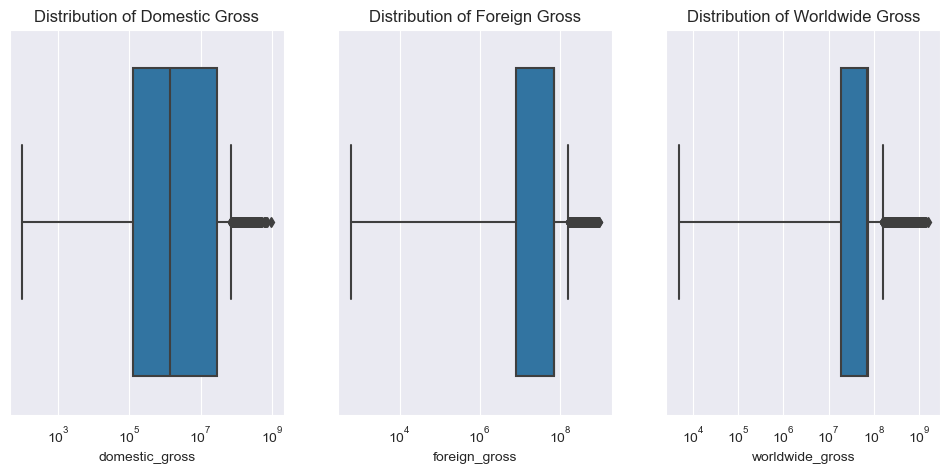

In [590]:
# creating the figure and axes
fig, axes = plt.subplots(ncols=3, figsize=(12, 5))

# set the style
sns.set_style('darkgrid')

# plot distribution for domestic gross
sns.boxplot(
    data=bom_df,
    x='domestic_gross',
    ax=axes[0]
)



# plot distribution for foreign gross
sns.boxplot(
    data=bom_df,
    x='foreign_gross',
    ax=axes[1]
)



# plot distribution for worldwide gross
sns.boxplot(
    data=bom_df,
    x='worldwide_gross',
    ax=axes[2]
)

# setting scale to log
axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')


# Labelling
axes[0].set_title('Distribution of Domestic Gross')
axes[1].set_title('Distribution of Foreign Gross')
axes[2].set_title('Distribution of Worldwide Gross');

### (c). Studios with highest Earnings

In [591]:
len(bom_df.studio.value_counts())

258

There are 257 Studios asociated with the movies. We get the studios with the highest earnings (worldwide gross)

In [592]:
# Get total earnings for each studio
total_studio_earnings = bom_df.groupby(
    'studio'
)['worldwide_gross'].sum()

# sorting the studios according to earnings
total_studio_earnings.sort_values(
    ascending=False,
    inplace=True
)

# get top 10 studios according to earnings
top_10_studios = total_studio_earnings[:10].reset_index()
top_10_studios

,studio,worldwide_gross
0,BV,44213702543
1,WB,31412801305
2,Fox,31020580426
3,Uni.,29967617711
4,Sony,22685523789
5,Par.,19924826363
6,WB (NL),10334796287
7,LGF,9215987696
8,IFC,6693197233
9,Magn.,5972688551


**Plot of the Top 10 Studio Earnings**

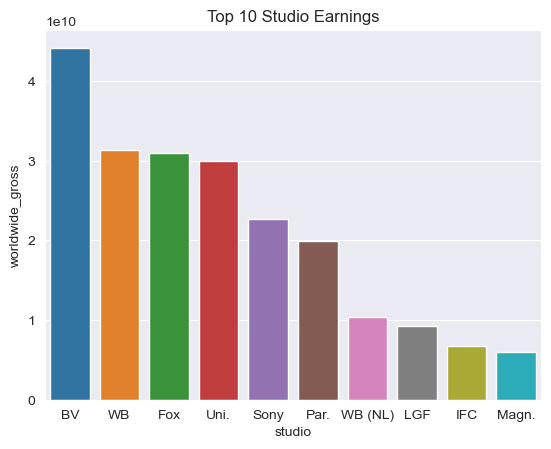

In [593]:
# bar plot of studio earnings
barplot = sns.barplot(
    data=top_10_studios,
    x='studio',
    y='worldwide_gross'
)
# labelling
barplot.set_title('Top 10 Studio Earnings');

Some of the top 10 earning studios include:
- BV studios
- Warner Bros studios
- Fox Studios
- universal studios
- Sony
- Paramount 
- Warner Bros. (New Line)
- Lionsgate Films (LGF)
- Independent Film Channel (IFC)
- Magnolia Pictures

### (d). Distribution of earnings over the years

In [594]:
# Creating grouped df of earnings by the years
yearly_earnings = bom_df.groupby(
    'year'
)['worldwide_gross'].sum().reset_index()

c:\Users\mutis\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mutis\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of earnings over the years')

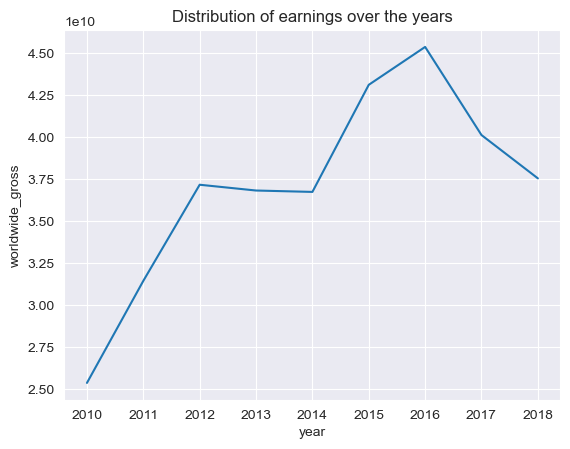

In [595]:
# Plotting the disribution over the years
ax = sns.lineplot(data=yearly_earnings, x='year', y='worldwide_gross')

# labelling
ax.set_title('Distribution of earnings over the years')

There is an increased trend in earnings over the years.

Highest Earning is recorded in 2016 and has decreased ever since. But the overal trend is Increasing

## 2. Best Ratings

We use the IMDB data to get some insights based on ratings.
- Best rated genres
- Best rated Writers
- Best rated Directors

### (a). Best rated genres

We use the genres df

In [597]:
# merge movie ratings and movie basics
ratings_df = movie_ratings.merge(genre_df, how='inner', on='movie_id')

ratings_df

,movie_id,averagerating_x,numvotes_x,averagerating_y,numvotes_y,primary_title,original_title,start_year,runtime_minutes,genres
0,tt10356526,8,31,8,31,Laiye Je Yaarian,Laiye Je Yaarian,2019,117,Romance
1,tt10384606,9,559,9,559,Borderless,Borderless,2019,87,Documentary
2,tt1042974,6,20,6,20,Just Inès,Just Inès,2010,90,Drama
3,tt1043726,4,50352,4,50352,The Legend of Hercules,The Legend of Hercules,2014,99,Action
4,tt1043726,4,50352,4,50352,The Legend of Hercules,The Legend of Hercules,2014,99,Adventure
...,...,...,...,...,...,...,...,...,...,...
129289,tt9844256,8,24,8,24,Code Geass: Lelouch of the Rebellion - Glorifi...,Code Geass: Lelouch of the Rebellion Episode III,2018,120,Sci-Fi
129290,tt9851050,5,14,5,14,Sisters,Sisters,2019,86,Action
129291,tt9851050,5,14,5,14,Sisters,Sisters,2019,86,Drama
129292,tt9886934,7,5,7,5,The Projectionist,The Projectionist,2019,81,Documentary
